In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import io
from tqdm import tqdm


def extract_stations(y=2024, url='https://www.ncei.noaa.gov/pub/data/uscrn/products/daily01/'):
    # Fetch the HTML content from the URL
    url = url+str(y)+'/'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all the links in the HTML
    links = soup.find_all('a')

    # Extract the file names from these links and parse out the station names
    stations = set()
    for link in links:
        filename = link.get('href')
        if filename and filename.endswith('.txt'):
            # Extract the station name, which includes the state abbreviation and additional details
            station_name = filename.split('-')[-1].split('.')[0]
            stations.add(station_name)
    # Convert the set to a DataFrame and save as CSV
    stations_df = pd.DataFrame(sorted(stations), columns=['Station'])
    stations_df.to_csv(f'stations{y}.csv', index=False)
    return list(stations)

def read2df (stations, ys=2002, ye=2023, url_template= 'https://www.ncei.noaa.gov/pub/data/uscrn/products/daily01/{}/CRND0103-{}-{}.txt'):
        
    # Initialize an empty DataFrame to store concatenated data
    concatenated_data = pd.DataFrame()
        
    # Define the total number of iterations for the progress bar
    total_iterations = len(range(ys, ye+1)) * len(stations)
    
    # Create a tqdm instance for the loops
    with tqdm(total=total_iterations) as pbar:
        # Loop through the years
        for year in range(ys, ye+1):
            # Loop through the stations
            for station in stations:
                # Increment progress bar
                pbar.update(1)
                
                # Format the URL for the specific year and station
                url = url_template.format(year, year, station)
                                
                # Send a GET request to download the file
                response = requests.get(url)
                
                # Check if the request was successful
                if response.status_code == 200:
                    # Read the text content of the response into a DataFrame
                    df = pd.read_csv(io.StringIO(response.text), delim_whitespace=True)
                    
                    # Add column headers
                    df.columns = ['WBANNO', 'LST_DATE', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'T_DAILY_MAX', 'T_DAILY_MIN', 'T_DAILY_MEAN',
                                  'T_DAILY_AVG', 'P_DAILY_CALC', 'SOLARAD_DAILY', 'SUR_TEMP_DAILY_TYPE', 'SUR_TEMP_DAILY_MAX',
                                  'SUR_TEMP_DAILY_MIN', 'SUR_TEMP_DAILY_AVG', 'RH_DAILY_MAX', 'RH_DAILY_MIN', 'RH_DAILY_AVG',
                                  'SOIL_MOISTURE_5_DAILY', 'SOIL_MOISTURE_10_DAILY', 'SOIL_MOISTURE_20_DAILY', 'SOIL_MOISTURE_50_DAILY',
                                  'SOIL_MOISTURE_100_DAILY', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY', 'SOIL_TEMP_20_DAILY',
                                  'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY']
                    
                    # Add a 'Station' column
                    df['Station'] = station

                    # Add a column for the first two characters of the station name
                    df['State_Code'] = station[:2]
                    
                    # Append the data for the current year and station to the concatenated_data DataFrame
                    concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

    return(concatenated_data)
    

# Extract stations
stations = extract_stations(y=2024)
print (stations)
df=read2df(stations, ys=2023, ye=2024)
df.to_csv('aaa_2024.csv', index=False)

['AL_Clanton_2_NE', 'TX_Austin_33_NW', 'AK_Cordova_14_ESE', 'LA_Lafayette_13_SE', 'AK_St', 'CA_Fallbrook_5_NE', 'AK_Bethel_87_WNW', 'MT_Wolf_Point_34_NE', 'NE_Lincoln_11_SW', 'MO_Salem_10_W', 'OR_John_Day_35_WNW', 'MI_Gaylord_9_SSW', 'KY_Bowling_Green_21_NNE', 'AL_Northport_2_S', 'WY_Lander_11_SSE', 'AL_Valley_Head_1_SSW', 'GA_Newton_8_W', 'CO_Dinosaur_2_E', 'SD_Sioux_Falls_14_NNE', 'AL_Courtland_2_WSW', 'CA_Bodega_6_WSW', 'TX_Muleshoe_19_S', 'AZ_Tucson_11_W', 'AK_Sitka_1_NE', 'OR_Riley_10_WSW', 'CA_Stovepipe_Wells_1_SW', 'KS_Oakley_19_SSW', 'TX_Palestine_6_WNW', 'CO_Nunn_7_NNE', 'ND_Northgate_5_ESE', 'CO_Cortez_8_SE', 'NH_Durham_2_N', 'HI_Mauna_Loa_5_NNE', 'KS_Manhattan_6_SSW', 'MI_Chatham_1_SE', 'NE_Lincoln_8_ENE', 'NV_Denio_52_WSW', 'NM_Socorro_20_N', 'VA_Charlottesville_2_SSE', 'GA_Watkinsville_5_SSE', 'AZ_Yuma_27_ENE', 'AK_Metlakatla_6_S', 'ND_Jamestown_38_WSW', 'AK_Utqiagvik_formerly_Barrow_4_ENE', 'IL_Champaign_9_SW', 'WV_Elkins_21_ENE', 'GA_Brunswick_23_S', 'SC_McClellanville_7

100%|████████████████████████████████████████████████████████████████████████████████| 314/314 [05:56<00:00,  1.14s/it]


In [8]:
filtered_data = df[df['T_DAILY_AVG'] != -9999]

# Convert LST_DATE to datetime and extract the year
filtered_data['Year'] = pd.to_datetime(filtered_data['LST_DATE'], format='%Y%m%d').dt.year
filtered_data = filtered_data[filtered_data['Year'] == 2024]
# Group by Station and Year, and count the number of days
days_per_station_year = filtered_data.groupby(['Station', 'Year', 'LONGITUDE', 'LATITUDE']).size().reset_index(name='Days')

# Display the result
print(days_per_station_year)
days_per_station_year.to_csv("2024stations_days.csv", index=False)


                Station  Year  LONGITUDE  LATITUDE  Days
0    AK_Aleknagik_1_NNE  2024    -158.61     59.28   167
1      AK_Bethel_87_WNW  2024    -164.08     61.35   147
2     AK_Cordova_14_ESE  2024    -145.35     60.47    77
3      AK_Deadhorse_3_S  2024    -148.46     70.16   167
4    AK_Fairbanks_11_NE  2024    -147.51     64.97   165
..                  ...   ...        ...       ...   ...
149    WI_Necedah_5_WNW  2024     -90.17     44.06   164
150    WV_Elkins_21_ENE  2024     -79.47     39.01   166
151    WY_Lander_11_SSE  2024    -108.67     42.68   164
152      WY_Moose_1_NNE  2024    -110.71     43.66   167
153   WY_Sundance_8_NNW  2024    -104.44     44.52   167

[154 rows x 5 columns]


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_2344\972848565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = pd.to_datetime(filtered_data['LST_DATE'], format='%Y%m%d').dt.year


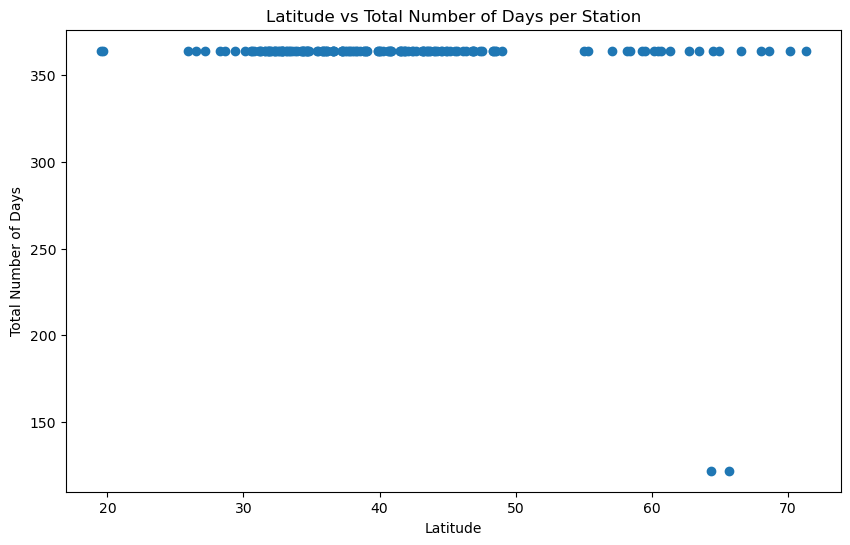

In [42]:
import matplotlib.pyplot as plt

# Step 1: Aggregate total number of days per station
total_days_per_station = filtered_data.groupby('Station').size().reset_index(name='Total_Days')

# Step 2: Get the latitude for each station (assuming one latitude per station)
station_latitudes = filtered_data[['Station', 'LATITUDE']].drop_duplicates()

# Step 3: Merge total days with latitude
station_days_with_lat = pd.merge(total_days_per_station, station_latitudes, on='Station')

# Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.scatter(station_days_with_lat['LATITUDE'], station_days_with_lat['Total_Days'])
plt.xlabel('Latitude')
plt.ylabel('Total Number of Days')
plt.title('Latitude vs Total Number of Days per Station')
plt.show()



In [43]:
print(days_per_station_year[days_per_station_year['Days'] < 360])

           Station  Year  LONGITUDE  LATITUDE  Days
6  AK_Galena_44_SW  2023    -158.08     64.34   122
8   AK_Huslia_27_E  2023    -155.48     65.66   122


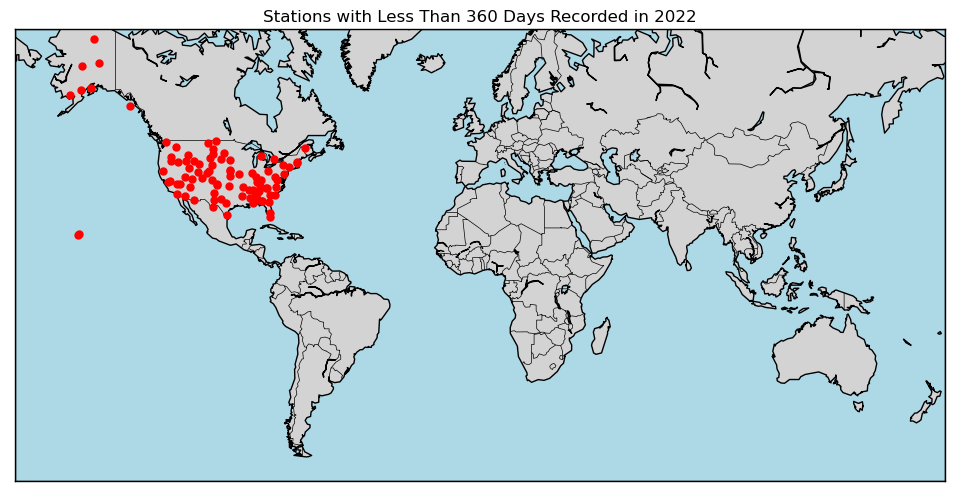

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Filter for stations with less than 360 days
stations_less_than_360 = days_per_station_year[days_per_station_year['Days'] > 362]

# Create a Basemap instance
plt.figure(figsize=(12, 8))
map = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray', lake_color='lightblue')
map.drawmapboundary(fill_color='lightblue')

# Plot each station
for _, row in stations_less_than_360.iterrows():
    x, y = map(row['LONGITUDE'], row['LATITUDE'])
    map.plot(x, y, 'o', markersize=5, color='red')

plt.title('Stations with Less Than 360 Days Recorded in 2022')
plt.show()


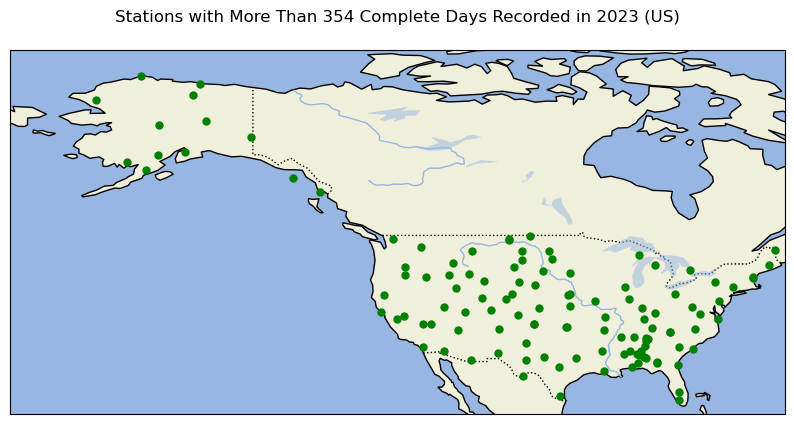

                  Station  Year  LONGITUDE  LATITUDE  Days
0      AK_Aleknagik_1_NNE  2023    -158.61     59.28   363
3        AK_Deadhorse_3_S  2023    -148.46     70.16   361
5      AK_Fairbanks_11_NE  2023    -147.51     64.97   363
9         AK_Kenai_29_ENE  2023    -150.45     60.72   363
10   AK_King_Salmon_42_SE  2023    -155.92     58.21   356
..                    ...   ...        ...       ...   ...
148     WA_Spokane_17_SSW  2023    -117.53     47.42   363
150      WV_Elkins_21_ENE  2023     -79.47     39.01   363
151      WY_Lander_11_SSE  2023    -108.67     42.68   363
152        WY_Moose_1_NNE  2023    -110.71     43.66   363
153     WY_Sundance_8_NNW  2023    -104.44     44.52   364

[122 rows x 5 columns]


In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Filter for stations with less than 360 days
stations_less_than_360 = days_per_station_year[days_per_station_year['Days'] > 354]

# Create a figure with an appropriate size
plt.figure(figsize=(10, 8))

# Create a GeoAxes with a specific extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-175, -66.5, 24, 75], crs=ccrs.PlateCarree())  # Setting extent to cover the US

# Add physical features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot each station
for _, row in stations_less_than_360.iterrows():
    ax.plot(row['LONGITUDE'], row['LATITUDE'], 'o', markersize=5, color='green', transform=ccrs.Geodetic())

# Set the title
ax.set_title('Stations with More Than 354 Complete Days Recorded in 2023 (US)', pad=20)

plt.show()

print (stations_less_than_360 )